In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [16]:
csv_path = Path("Housing.csv")
df = pd.read_csv(csv_path)
target_col = "price"
y = df[target_col].values
X = df.drop(columns=[target_col, "rownames"])
numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(exclude="number").columns.tolist()
X.head()

,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,5850,3,1,2,yes,no,yes,no,no,1,no
1,4000,2,1,1,yes,no,no,no,no,0,no
2,3060,3,1,1,yes,no,no,no,no,0,no
3,6650,3,1,2,yes,yes,no,no,no,0,no
4,6360,2,1,1,yes,no,no,no,no,0,no


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# 1) train/test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 2) train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_tmp, y_tmp, test_size=0.2, random_state=42
)

# Препроцессинг: числовые -> median, категориальные -> most_frequent + OneHot
numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("cat", categorical_tf, categorical_features),
])

# Fit только на train, transform train/valid/test
preprocess.fit(X_train)
X_tr = preprocess.transform(X_train)
X_va = preprocess.transform(X_valid)
X_te = preprocess.transform(X_test)

# Соберём имена признаков после OHE
oh = preprocess.named_transformers_["cat"].named_steps["onehot"] if categorical_features else None
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

X_tr.shape, X_va.shape, X_te.shape, len(feature_names)

((348, 17), (88, 17), (110, 17), 17)

In [18]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=-1,

    eval_metric="rmse",
    early_stopping_rounds=50
)

xgb.fit(
    X_tr, y_train,
    eval_set=[(X_va, y_valid)]
)

[0]	validation_0-rmse:26755.94384
[1]	validation_0-rmse:26199.39300
[2]	validation_0-rmse:25520.44607
[3]	validation_0-rmse:24873.32719
[4]	validation_0-rmse:24227.49190
[5]	validation_0-rmse:23426.67059
[6]	validation_0-rmse:22931.15674
[7]	validation_0-rmse:22340.17840
[8]	validation_0-rmse:21891.37453
[9]	validation_0-rmse:21263.13836
[10]	validation_0-rmse:21021.28277
[11]	validation_0-rmse:20561.54281
[12]	validation_0-rmse:20219.23799
[13]	validation_0-rmse:20027.10868
[14]	validation_0-rmse:19658.58781
[15]	validation_0-rmse:19319.96030
[16]	validation_0-rmse:19115.09877
[17]	validation_0-rmse:18806.80272
[18]	validation_0-rmse:18524.05307
[19]	validation_0-rmse:18245.77573
[20]	validation_0-rmse:18031.55324
[21]	validation_0-rmse:17728.29052
[22]	validation_0-rmse:17549.07540
[23]	validation_0-rmse:17368.68997
[24]	validation_0-rmse:17241.24137
[25]	validation_0-rmse:17142.71163
[26]	validation_0-rmse:17026.09366
[27]	validation_0-rmse:16855.46003
[28]	validation_0-rmse:16736.3

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [19]:
from sklearn.metrics import mean_squared_error, r2_score


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5  # совместимо с любой версией sklearn

y_pred = xgb.predict(X_te)
print(f"R^2 (test): {r2_score(y_test, y_pred):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred):,.2f}")

# лучшая итерация по ранней остановке
print("Best iteration:", xgb.best_iteration)

R^2 (test): 0.6630
RMSE (test): 15,003.60
Best iteration: 67


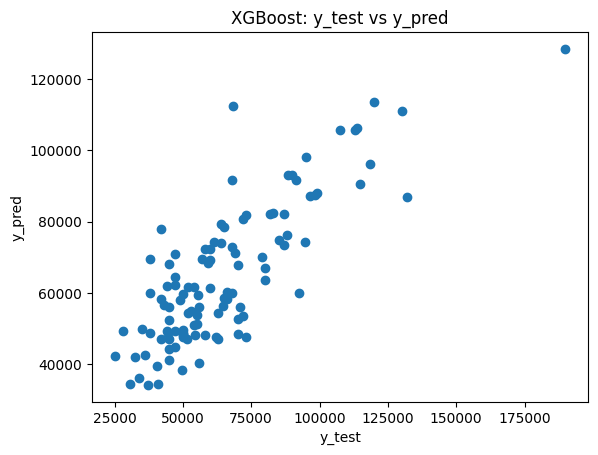

In [20]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("XGBoost: y_test vs y_pred")
plt.xlabel("y_test"); plt.ylabel("y_pred")
plt.show()

In [21]:

importances = xgb.feature_importances_
imp_df = (pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
})
.sort_values("importance", ascending=False)
.head(15))

imp_df

,feature,importance
2,bathrms,0.203984
13,airco_no,0.090561
6,driveway_yes,0.074611
0,lotsize,0.073035
14,airco_yes,0.066515
9,fullbase_no,0.063456
11,gashw_no,0.063297
4,garagepl,0.048946
5,driveway_no,0.043487
15,prefarea_no,0.042894


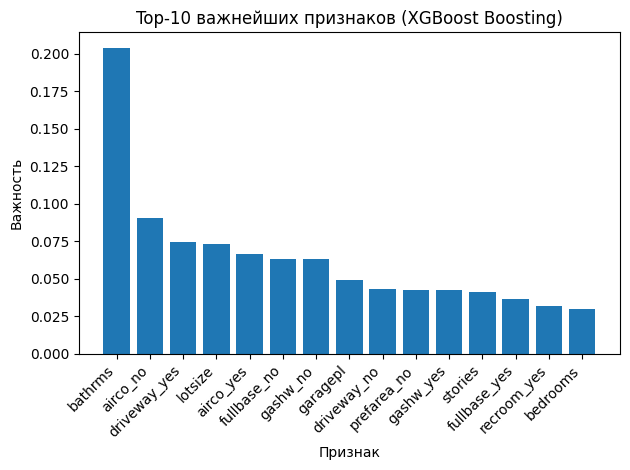

In [22]:
plt.figure()
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Top-10 важнейших признаков (XGBoost Boosting)")
plt.xlabel("Признак")
plt.ylabel("Важность")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()